In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import argparse
import breizhcrops
import torch
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [4]:
print(torch.__version__)

1.6.0


In [5]:
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

# Define params and datapath

In [6]:
# insert breizhcrops dataset path
abs_path= '/home/mauromartini/mauro_ws/Remote_sensing_DANN/breizhcrops_dataset'
# path = '.../breizhcrops_dataset'
datapath = Path(abs_path)
print(datapath)
mode = 'all_zones'
batch_size = 256
learning_rate = 0.001

weight_decay = 5e-08
workers = 0

/home/mauromartini/mauro_ws/Remote_sensing_DANN/breizhcrops_dataset


# Define Dataloader

In [7]:
from utils.data_load import *
from utils.metrics import metrics

In [8]:
# if we want to import all zones data
zone1dataset, zone2dataset, zone3dataset, zone4dataset, meta = get_datasets(datapath=datapath, mode=mode,
                                                        batchsize=batch_size, 
                                                        preload_ram=True, level="L2A")

loading data into RAM:   0%|          | 0/178632 [00:00<?, ?it/s]

Setting up datasets in /home/mauromartini/mauro_ws/Remote_sensing_DANN/breizhcrops_dataset, level L2A


loading data into RAM: 100%|██████████| 122708/122708 [00:34<00:00, 3578.28it/s]


In [9]:
num_classes = meta["num_classes"]
ndims = meta["ndims"]
sequencelength = meta["sequencelength"]

In [10]:
zone1dataloader, zone2dataloader, zone3dataloader, zone4dataloader = get_dataloader2(zone1dataset, zone2dataset, 
                                                                                     zone3dataset, zone4dataset,
                                                                                     batchsize=batch_size, 
                                                                                     workers=workers)

# Define DANN Transformer

In [11]:
# Transformer params
#ndims=10
#num_classes=9
#sequencelength=45
        
d_model=64
n_head=2
n_layers=3
d_inner=128

In [12]:
from utils.DANN_Transformer_model import ViTransformerExtractor, ViTransformerDANN

feature_ex = ViTransformerExtractor(input_dim=ndims, n_head=n_head, n_layers=n_layers, 
                                    activation="relu",).to(device)
dann_model = ViTransformerDANN(feature_ex, input_dim=ndims, num_classes=num_classes, n_layers = n_layers, 
                                    n_domain=2,
                                    activation="relu",).to(device)

dann_model.modelname += f"_learning-rate={learning_rate}_weight-decay={weight_decay}"
print(f"Initialized {dann_model.modelname}")

logdir = 'logs/torch_transformer_dann/'

print(f"Initialized {dann_model.modelname}")
os.makedirs(logdir, exist_ok=True)
print(f"Logging results to {logdir}")

Initialized TransformerEncoder_input-dim=10_num-classes=9_d-model=64_d-inner=128_n-layers=3_n-head=2_dropout=0.1_learning-rate=0.001_weight-decay=5e-08
Initialized TransformerEncoder_input-dim=10_num-classes=9_d-model=64_d-inner=128_n-layers=3_n-head=2_dropout=0.1_learning-rate=0.001_weight-decay=5e-08
Logging results to logs/torch_transformer_dann/


# Make Predictions on test

In [13]:
from utils.test import test_epoch

dataloaders = [(zone1dataloader,'zone1'), (zone2dataloader,'zone2'), (zone3dataloader,'zone3'), (zone4dataloader,'zone4')]
feature_ex = ViTransformerExtractor(input_dim=ndims, n_head = n_head, n_layers = n_layers, activation="relu",).to(device)
dann_model = ViTransformerDANN(feature_ex, input_dim=ndims, num_classes=num_classes,
                                n_layers = n_layers, n_domain=2,activation="relu",).to(device)

path = 'models/vio_trasformer_dann_s2_t3_maxalpha02_gamma10/archive.zip'
model_dir = Path(path)
dann_model.load_state_dict(torch.load(model_dir))

criterion = torch.nn.CrossEntropyLoss(reduction="mean")

# SET TARGET DATA
ZONE = 3 #indicate the number of the desired target zone
testdataloader = dataloaders[ZONE-1][0]
test_zone = dataloaders[ZONE-1][1]
print('Target zone:', test_zone)

test_loss, y_true, y_pred, *_ = test_epoch(dann_model, criterion, testdataloader, device)

scores = metrics(y_true.cpu(), y_pred.cpu())
scores_msg = ", ".join([f"{k}={v:.2f}" for (k, v) in scores.items()])

test_loss = test_loss.cpu().detach().numpy()[0]
print(scores)

test loss=1.55:   0%|          | 0/650 [00:00<?, ?it/s]

Target zone: zone3


test loss=1.62: 100%|██████████| 650/650 [00:51<00:00, 12.62it/s]


{'accuracy': 0.650868261133518, 'kappa': 0.5486064588888706, 'f1_micro': 0.650868261133518, 'f1_macro': 0.4548572490891729, 'f1_weighted': 0.6570353093945736, 'recall_micro': 0.650868261133518, 'recall_macro': 0.456115055397908, 'recall_weighted': 0.650868261133518, 'precision_micro': 0.650868261133518, 'precision_macro': 0.4749897453030854, 'precision_weighted': 0.6813460521580915}


/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mauromartini/.virtualenvs/pytorch/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
label_names = ['barley', 'wheat', 'rapeseed', 'corn', 'sunflower', 'orchards',
       'nuts', 'permanent_meadows', 'temporary_meadows']

In [15]:
y_pred_names = [label_names[i] for i in y_pred]

In [16]:
field_parcels_geodataframe_dann = zone3dataset.geodataframe()
field_parcels_geodataframe = zone3dataset.geodataframe()
field_parcels_geodataframe_dann['classname'] = y_pred_names

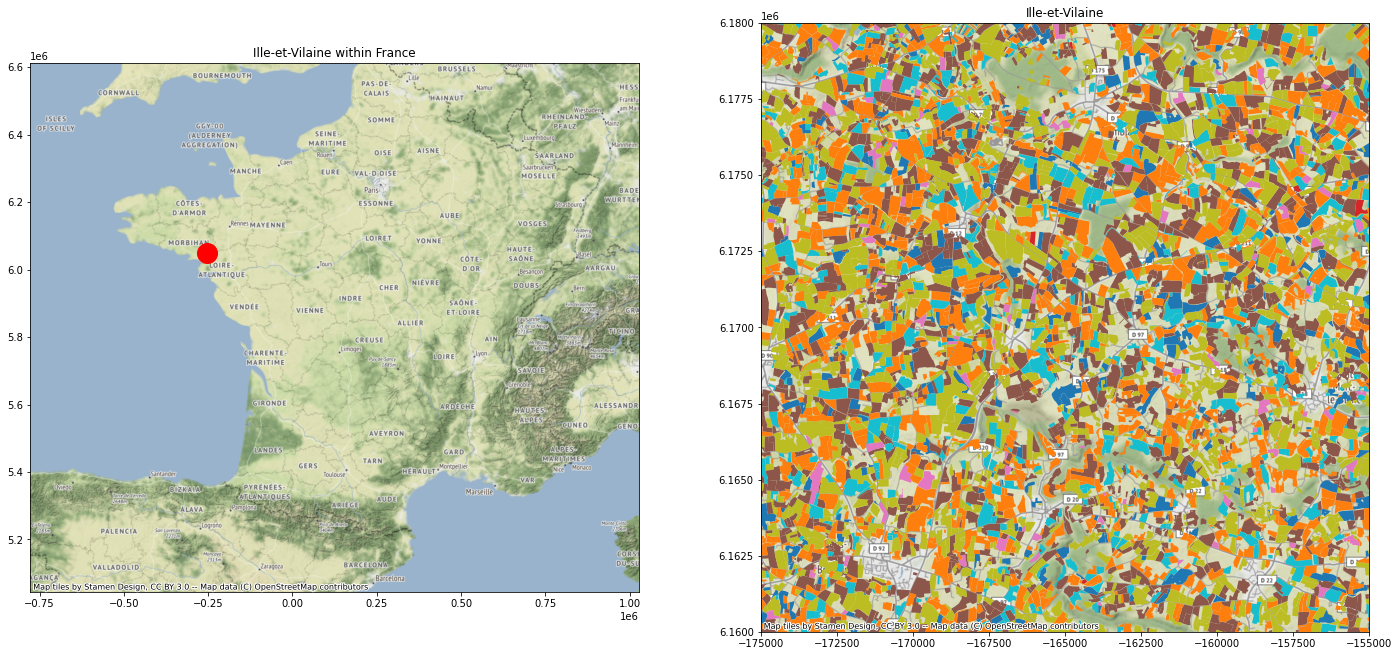

In [17]:
import contextily as ctx
fig,axs = plt.subplots(1,2, figsize=(24,12))

ax = axs[0]
france_xlim = (-777823.199830,  1027313.660153)
france_ylim = (5043620.874369, 6613943.183460)
ax.set_xlim(*france_xlim)
ax.set_ylim(*france_ylim)

ctx.add_basemap(ax)

ymin, xmin, ymax, xmax = field_parcels_geodataframe.to_crs(epsg=3857).total_bounds
#ax.plot([xmin,xmin,xmax,xmax, xmin],[ymin,ymax,ymax,ymin, ymin])
ax.plot([ymin],[xmin],"ro", markersize=20)
ax.set_title("Ille-et-Vilaine within France")

ax = axs[1]
ax = field_parcels_geodataframe_dann.to_crs(epsg=3857).plot(column="classname", ax=ax, legend=False)
ax.set_title("Ille-et-Vilaine")
ax.set_xlim(*(-175000,  -155000))
ax.set_ylim(*(6160000, 6180000))
ctx.add_basemap(ax)

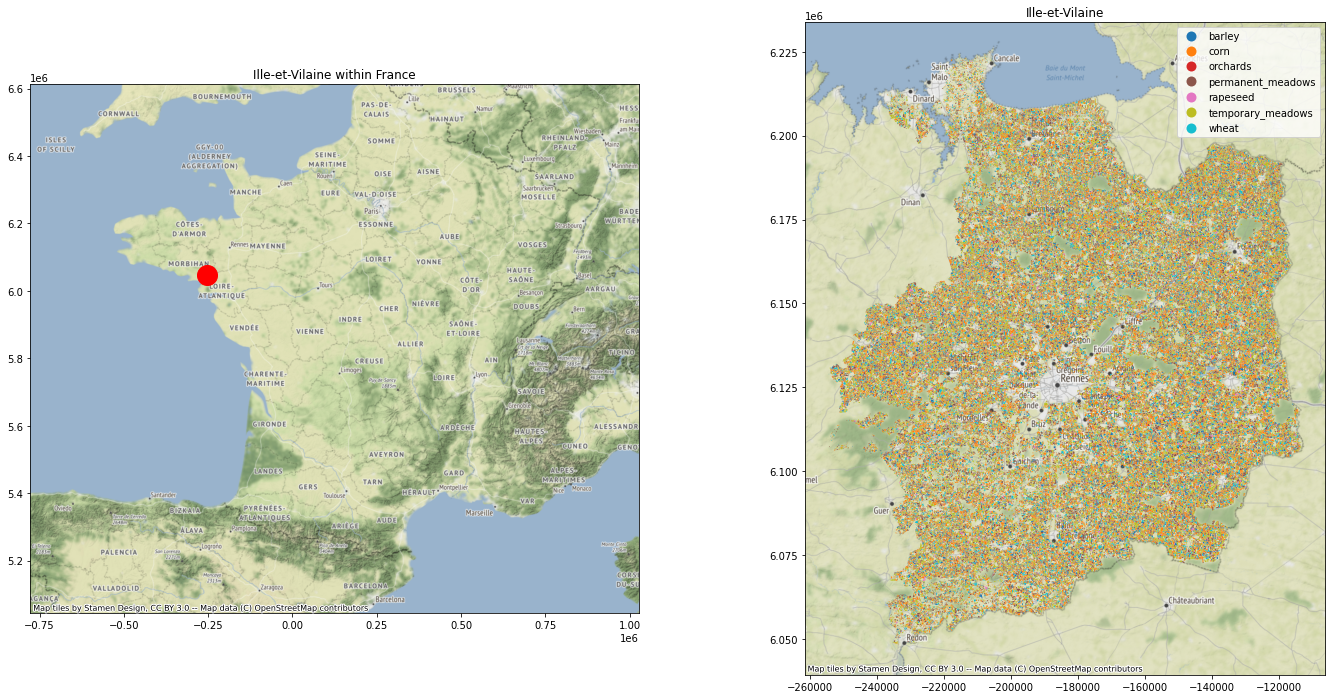

In [18]:
import contextily as ctx
fig,axs = plt.subplots(1,2, figsize=(24,12))

ax = axs[0]
france_xlim = (-777823.199830,  1027313.660153)
france_ylim = (5043620.874369, 6613943.183460)
ax.set_xlim(*france_xlim)
ax.set_ylim(*france_ylim)

ctx.add_basemap(ax)

ymin, xmin, ymax, xmax = field_parcels_geodataframe.to_crs(epsg=3857).total_bounds
#ax.plot([xmin,xmin,xmax,xmax, xmin],[ymin,ymax,ymax,ymin, ymin])
ax.plot([ymin],[xmin],"ro", markersize=20)
ax.set_title("Ille-et-Vilaine within France")

ax = axs[1]
ax = field_parcels_geodataframe_dann.to_crs(epsg=3857).plot(column="classname", ax=ax, legend=True)
ax.set_title("Ille-et-Vilaine")
ctx.add_basemap(ax)